Name: Smoothing scattered data | Author: Alf Köhn-Seemann | Version 2023-02-17 | License: CC BY 4.0
***
# Smoothing scattered data

Some introductory words are missing

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]    # [width, height] in inches

As a next step, we create an array from 0 to $2\pi$ and calculate the sine of those values. We will add a noise of 25 % to the sine to get scattered data.

In [2]:
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100)*0.25

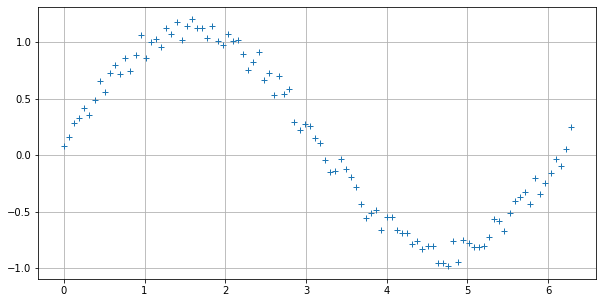

In [3]:
plt.plot(x,y, linestyle='none', marker='+')
plt.grid()
plt.show()

## Method 1

As a first possibility, we will apply a moving average box making use of numpy's convolve function.

In [4]:
def smooth_convolve(y, box_size):
    box = np.ones(box_size)/box_size
    return np.convolve(y, box, mode='same') 

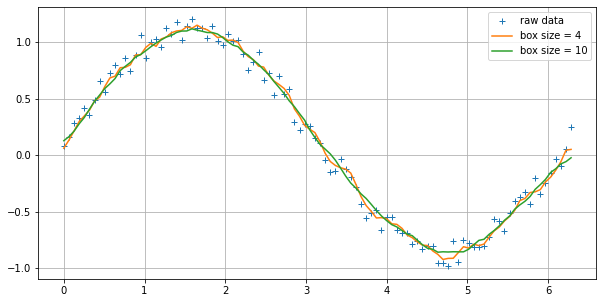

In [5]:
plt.plot(x,y, linestyle='none', marker='+', label='raw data')
plt.plot(x, smooth_convolve(y,4), label='box size = 4')
plt.plot(x, smooth_convolve(y,10), label='box size = 10')
plt.legend()
plt.grid()
plt.show()

## Method 2

The second possiblity is actually based on the same idea as method 1, it is just much faster by using `numpy.cumsum`, which calculate the cumulative sum of an array. Note that this method is at least an order of magnitude faster than using `numpy.convolve`.

In [6]:
def smooth_cumsum(arr, window_width):
    # duplicate edge values, to ensure cumsum-vector is same length as original array 
    # if window-size is odd, adding 0 at the beginning of data is necessary
    if window_width%2 > 0:
        arr = np.insert(arr, 0, 0)
    arr = np.pad( arr, int(window_width/2) , mode='edge')
    
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

    return moving_average

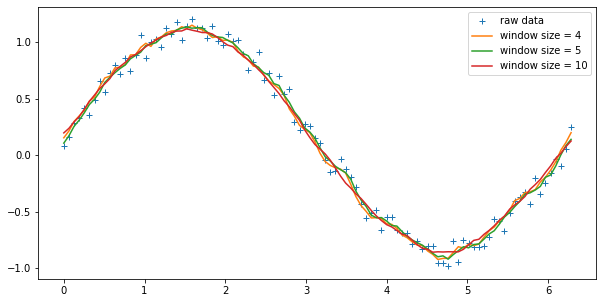

In [7]:
plt.plot(x,y, linestyle='none', marker='+', label='raw data')
plt.plot(x, smooth_cumsum(y,4), label='window size = 4')
plt.plot(x, smooth_cumsum(y,5), label='window size = 5')
plt.plot(x, smooth_cumsum(y,10), label='window size = 10')
plt.legend()
plt.show()

## Method 3

Another built-in version of scipy applying a moving average window: here, the arithmetic average of each pixel with its neighbor is calculated, where the size of the sub-array is used to calculate arithmetic average.

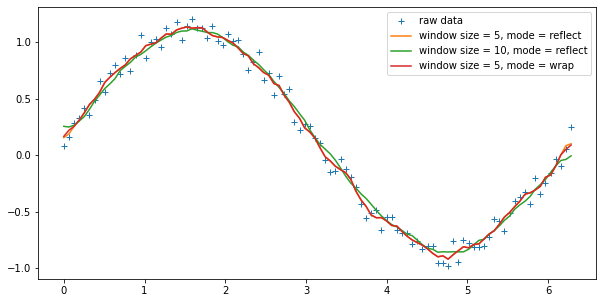

In [8]:
from scipy.ndimage import uniform_filter1d

plt.plot(x,y, linestyle='none', marker='+', label='raw data')
plt.plot(x, uniform_filter1d(y, size=5, mode='reflect'), label='window size = 5, mode = reflect')
plt.plot(x, uniform_filter1d(y, size=10, mode='reflect'), label='window size = 10, mode = reflect')
plt.plot(x, uniform_filter1d(y, size=5, mode='wrap'), label='window size = 5, mode = wrap')
plt.legend()
plt.show()

## Method 4

Here we will apply a so-called Savitzky-Golay filter [1] which uses least square fit to fit a polynomial to a small window of the data, then get the center point of the window from that polynomial. The window is shifted forward point by point. This method is known to work very well even with very noisy data in particular when they are of non-periodic and/or non-linear character. Fortunately, this filter is included in the SciPy package [2].

[1] https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

[2] https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

In [9]:
from scipy.signal import savgol_filter

def smooth_savgol(arr, wSize, polOrder=3):
    if wSize%2 == 0:
        wSize += 1
        print("Warning: smooth_savgol requires window size to be an odd number")
        print("         will add +1, thus window size used it '{0}'".format(wSize))
    return savgol_filter(y, wSize, polOrder)

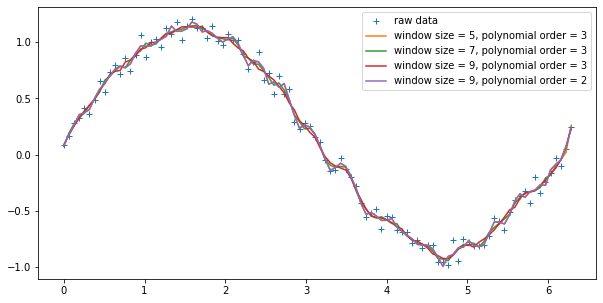

In [10]:
wSize = 5
polOrder = 3

plt.plot(x,y, linestyle='none', marker='+', label='raw data')
plt.plot(x, smooth_savgol(y, wSize, polOrder), label='window size = 5, polynomial order = 3')
plt.plot(x, smooth_savgol(y, 7, polOrder), label='window size = 7, polynomial order = 3')
plt.plot(x, smooth_savgol(y, 9, polOrder), label='window size = 9, polynomial order = 3')
plt.plot(x, smooth_savgol(y, 5, 2), label='window size = 9, polynomial order = 2')
plt.legend()
plt.show()

## Method 5

The technique of Locally Weighted Scatterplot Smoothing (LOWESS) is applied now. It was developed in 1979 by William Cleveland [1] and it corresponds to a generalization of the LOESS (LOcally Estimated Scatterplot Smoothing) method. LOWESS is calculated piecewise as a series of least-square fits on a nearest-neighbor subset of the data, where in each fit, points within the nearest-neighbor windows are weighted by the procximity to the central point. The weighting function can vary, which seems to be the major difference compared to the Savitzky-Golay filter method.

We will use the python `Statsmodel` implementation of LOWESS. Its input parameter `frac` specifies the fraction of the data to be used in each regression (smaller fraction corresponding to smaller window-sizes). Note that the return value is a n-by-2 array, with the first column corresponding to the x-values and second column to the y-values.

[1] http://home.eng.iastate.edu/~shermanp/STAT447/Lectures/Cleveland%20paper.pdf

[]

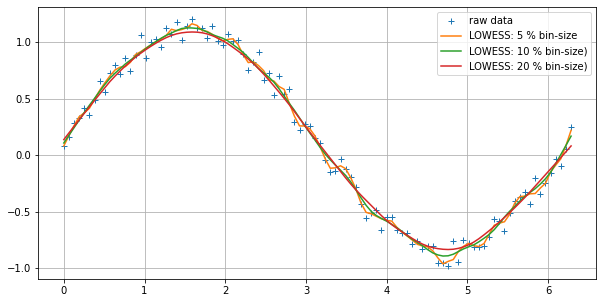

In [11]:
from statsmodels.nonparametric.smoothers_lowess import lowess

lowess_small = lowess(y, x, frac=.05)
lowess_medium = lowess(y, x, frac=.1)
lowess_large = lowess(y, x, frac=.2)

plt.plot(x,y, linestyle='none', marker='+', label='raw data')
plt.plot(lowess_small[:,0], lowess_small[:,1], label='LOWESS: 5 % bin-size')
plt.plot(lowess_medium[:,0], lowess_medium[:,1], label='LOWESS: 10 % bin-size)')
plt.plot(lowess_large[:,0], lowess_large[:,1], label='LOWESS: 20 % bin-size)')
plt.legend()
plt.grid()
plt.plot()

## Run-time comparison

Let's now compare the run-time of the different methods. Instead of writing a function to do so, we use the built-in method `%%timeit` which measures the run-time per cell by executing it repeatedly. Note that we don't want to use `%timeit` as this is intended to be used for single line commands, often written in the same line separated simply by a blank.

We will use a larger data array to be closer to a situation relevant to actual data analysis.

In [12]:
wSize = 20
N_pts = 1000
x = np.linspace(0,2*np.pi,N_pts)
y = np.sin(x) + np.random.random(N_pts)*0.25

In [13]:
%%timeit
foo = smooth_convolve(y, wSize)

31.7 µs ± 3.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit
foo = smooth_cumsum(y, wSize)

41.4 µs ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%%timeit
wSize = 21
foo = smooth_savgol(y, wSize)

439 µs ± 40 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
foo = uniform_filter1d(y, size=5, mode='reflect')

10.3 µs ± 188 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
%timeit foo = smooth_convolve(y, wSize)
%timeit foo = smooth_cumsum(y, wSize)
%timeit foo = uniform_filter1d(y, size=wSize, mode='reflect')
%timeit foo = smooth_savgol(y, wSize+1)

33.3 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
45 µs ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
10.8 µs ± 289 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
471 µs ± 55.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
